# Introduction

I've found it helpful to have one notebook build up a cache of the data I want to analyze. I'm still not quite sure if anndata or loom is a better choice.

This notebook is to collect the 10x e10.5 forelimb runs.

In [1]:
import collections
import pandas
import scanpy
import scipy
from pathlib import Path
import sys
from urllib import parse
from matplotlib import pyplot
from matplotlib import cm
import loompy
import numpy
import anndata
import scanpy
import upsetplot

from common import (scanpy_load_solo_mtx, scanpy_load_alevin_mtx, scanpy_load_kallisto_gene_mtx, build_anndata)

In [2]:
%matplotlib inline

In [3]:
LRSC = str(Path('~/proj/long-rna-seq-condor').expanduser())
if LRSC not in sys.path:
    sys.path.append(LRSC)
from woldrnaseq.madqc import load_rsem_quantifications, load_genomic_quantifications, load_transcriptome_quantifications, replicate_scores
from woldrnaseq.models import load_library_tables, load_experiments, load_all_star_final, load_all_star_counts

Borrowed from <a href="https://github.com/pachterlab/MBGBLHGP_2019/blob/ff34c984dd0cc06e82538241e17888f2e6b070d5/Figure_2_Supplementary_Figure_3/make_plot.py#L66">Figure 2a code</a>

In [4]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [5]:
project_dir = Path('~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/').expanduser()
genome_dir = project_dir /'genome'/'mm10-M21_minimal-male'
analysis_dir = project_dir / 'ENCSR874BOF_e10_5_minimal_limb'

# Load GTF

In [6]:
store = pandas.HDFStore(genome_dir / 'mm10-M21_minimal-male.h5')
gtf = store[store.keys()[0]]
store.close()

# Load Transcript Map

In [7]:
def load_transcript_map(genome_dir):
    txp_map = {}
    with open(genome_dir/'txp2gene.tsv', 'rt') as instream:
        for line in instream:
            txp, gene = line.rstrip().split('\t')
            txp_map[txp] = gene
    return txp_map


In [8]:
mm10_M21_minimal_map = load_transcript_map(genome_dir)
len(mm10_M21_minimal_map)

115440

In [9]:
def compute_pearson(left, right):
    assert left.shape == right.shape, "Shapes must be the same"    
    if isinstance(left, anndata._core.anndata.AnnData):
        left = left.X.todense()
    if isinstance(right, anndata._core.anndata.AnnData):
        right = right.X.todense()
        
    cors = []
    for i in range(left.shape[1]):
        cors.append(scipy.stats.pearsonr(left[:,i].A.ravel(), right[:,i].A.ravel())[0])
    cors = numpy.array(cors)[~numpy.isnan(cors)]
        
    return cors

In [10]:
def compute_spearman(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    if isinstance(left, anndata._core.anndata.AnnData):
        left = left.X.todense()
    if isinstance(right, anndata._core.anndata.AnnData):
        right = right.X.todense()

    cors=[]
    for i in range(left.shape[1]):
        cors.append(scipy.stats.spearmanr(left[:,i], right[:,i])[0])
    cors = numpy.array(cors)[~numpy.isnan(cors)]
    return cors


In [11]:
def sparse_M_std(X):
    n = X.shape[1]
    return numpy.sqrt(n * X.multiply(X).sum(1) - numpy.multiply(X.sum(1), X.sum(1)))

def sparse_M_pearson_corr(X,Y):
    X_std = sparse_M_std(X)
    Y_std = sparse_M_std(Y)
    XY_std = numpy.multiply(X_std, Y_std)

    n = X.shape[1]
    XY_cov = n * X.multiply(Y).sum(1) - numpy.multiply(X.sum(1), Y.sum(1))
    R = numpy.divide(XY_cov, XY_std)
    return numpy.squeeze(numpy.asarray(R))

In [12]:
def load_barcode_list(filename):
    with open(filename) as instream:
        barcodes = list(set([line.strip() for line in instream]))
    return barcodes

# Load Single Cell tables

In [13]:
solo_filtered = scanpy_load_solo_mtx(analysis_dir / 'star_solo', mode='filtered')
solo_filtered.shape

(6289, 31635)

In [14]:
alevin_decoy = scanpy_load_alevin_mtx(
    analysis_dir / 'alevin_decoy')

In [15]:
alevin_decoy = scanpy_load_alevin_mtx(
    analysis_dir / 'alevin_decoy', 
    force_var_names=solo_filtered.var_names,
)
alevin_decoy.shape

(7302, 31635)

In [16]:
alevin_decoy_barcodes = load_barcode_list(analysis_dir / 'alevin_decoy' / 'alevin' / 'whitelist.txt')

In [17]:
alevin_decoy_filtered = alevin_decoy[alevin_decoy_barcodes]

In [18]:
alevin = scanpy_load_alevin_mtx(
    analysis_dir / 'alevin',
    force_var_names=solo_filtered.var_names,
)
alevin.shape

(7302, 31635)

In [19]:
alevin_barcodes = load_barcode_list(analysis_dir / 'alevin' / 'alevin' / 'whitelist.txt')

In [20]:
alevin_filtered = alevin[alevin_barcodes]

In [21]:
cellranger_raw = scanpy.read_10x_mtx(
    analysis_dir / 'ENCSR874BOF-minimal-e10_5-count-cells10000/outs/raw_feature_bc_matrix',
    var_names='gene_ids'
)
cellranger_raw.obs_names = [x[:-2] for x in cellranger_raw.obs_names]
cellranger_raw.obs['counts'] = cellranger_raw.X.sum(axis=1)
cellranger_raw.obs['ngenes'] = numpy.array((cellranger_raw.X > 0).sum(axis=1))

cellranger_raw.shape

(737280, 31635)

In [22]:
cellranger_filtered = scanpy.read_10x_mtx(
    analysis_dir / 'ENCSR874BOF-minimal-e10_5-count-cells10000/outs/filtered_feature_bc_matrix',
    var_names='gene_ids'
)
cellranger_filtered.obs_names = [x[:-2] for x in cellranger_filtered.obs_names]
cellranger_filtered.obs['counts'] = cellranger_filtered.X.sum(axis=1)
cellranger_filtered.obs['ngenes'] = numpy.array((cellranger_filtered.X > 0).sum(axis=1))

cellranger_filtered.shape

(7598, 31635)

In [23]:
solo_raw = scanpy_load_solo_mtx(analysis_dir / 'star_solo', mode='raw')
solo_raw.shape

(737280, 31635)

# Load Kallisto

In [24]:
kallisto_raw = scanpy_load_kallisto_gene_mtx(analysis_dir / 'kallisto' / 'genecount')
kallisto_raw.shape

(584238, 31635)

In [25]:
kallisto_filtered_barcodes = load_barcode_list(analysis_dir / 'kallisto' / 'filtered-barcodes.txt')

In [26]:
kallisto_filtered = kallisto_raw[kallisto_filtered_barcodes]
kallisto_filtered.shape

(7835, 31635)

# Load Kallisto EM

In [27]:
kallisto_em_raw = scanpy_load_kallisto_gene_mtx(analysis_dir / 'kallisto_em' / 'genecount')
print('Kallisto_em_raw shape', kallisto_em_raw.shape)
kallisto_em_filtered_barcodes = load_barcode_list(analysis_dir / 'kallisto_em' / 'filtered-barcodes.txt')
kallisto_em_filtered = kallisto_em_raw[kallisto_em_filtered_barcodes]
print('Kallisto_em_filtered shape', kallisto_em_filtered.shape)

Kallisto_em_raw shape (584238, 31635)
Kallisto_em_filtered shape (7835, 31635)


In [28]:
assert numpy.all(solo_filtered.var_names == cellranger_filtered.var_names)
assert numpy.all(kallisto_raw.var_names == solo_filtered.var_names)

In [29]:
kallisto_barcodes_counted = collections.Counter(kallisto_filtered_barcodes)

In [60]:
upset_contents = {
    'cell ranger': cellranger_raw.obs_names,
    'star solo': solo_raw.obs_names,
    'kallisto': kallisto_raw.obs_names,
    'kallisto_em': kallisto_em_raw.obs_names,
    'alevin': alevin_decoy.obs_names,
}

for alg in upset_contents:
    if len(upset_contents[alg]) != len(set(upset_contents[alg])):
        print(alg)

upset_gene_contents = upsetplot.from_contents(upset_contents)

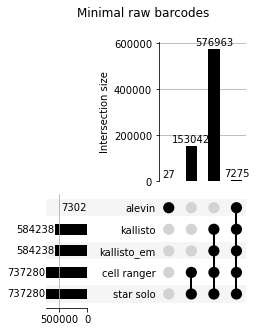

In [61]:
f = pyplot.figure()
f.suptitle('Minimal raw barcodes')
_ = upsetplot.plot(upset_gene_contents, fig=f, show_counts=True)


In [58]:
upset_contents = {
    'cell ranger': cellranger_filtered.obs_names,
    'star solo': solo_filtered.obs_names,
    'kallisto': kallisto_filtered_barcodes,
    'kallisto_em': kallisto_em_filtered_barcodes,
    'alevin': alevin_decoy.obs_names,
    'alevin filtered': alevin_decoy_barcodes,
}

for alg in upset_contents:
    if len(upset_contents[alg]) != len(set(upset_contents[alg])):
        print(alg)

upset_gene_contents = upsetplot.from_contents(upset_contents)

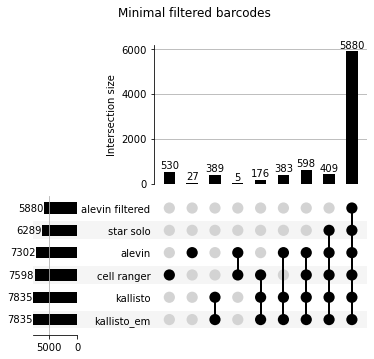

In [59]:
f = pyplot.figure()
f.suptitle('Minimal filtered barcodes')
_ = upsetplot.plot(upset_gene_contents, fig=f, show_counts=True)

In [32]:
colors = { x: cm.tab10(i) for i, x in enumerate([
    'alevin filtered',
    'alevin',
    'alevin decoy',
    'cell ranger',
    'kallisto',
    'kallisto_em',
    'star solo',
])}

This is adapted from the <a href="https://github.com/pachterlab/MBGBLHGP_2019/blob/ff34c984dd0cc06e82538241e17888f2e6b070d5/Figure_2_Supplementary_Figure_3/make_plot.py#L114">code</a> for figure 2a from <a href="https://www.biorxiv.org/content/10.1101/673285v2.full">Modular and efficient pre-processing of single-cell RNA-seq</a>.

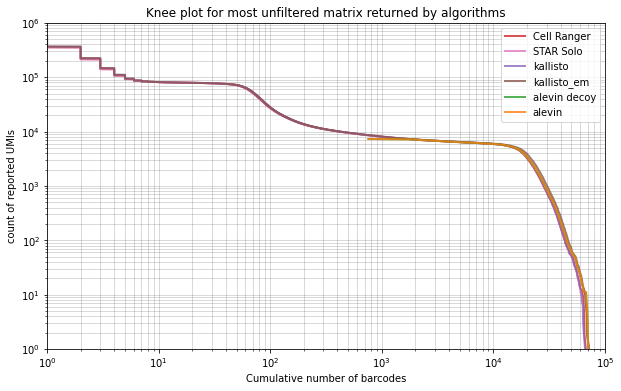

In [66]:
f = pyplot.figure(figsize=(10,6))
ax = f.add_subplot(1,1,1)

alpha = 0.8
gridalpha = 0.5
fontsize = 12
#max_barcodes = max(cellranger_raw.X.shape[0], solo_raw.X.shape[0], kallisto_raw.X.shape[0], alevin_decoy.X.shape[0], alevin.X.shape[0])
#tenx_ranked_umi[0:np.shape(kallisto.X)[0]], np.arange(np.shape(kallisto.X)[0])

ax.set_title('Knee plot for most unfiltered matrix returned by algorithms')
cellranger_ranked_umi = numpy.sort(numpy.array(cellranger_raw.obs['counts']), axis=None)[::-1]
ax.plot(cellranger_ranked_umi, range(cellranger_ranked_umi.shape[0]), linewidth=2, alpha=alpha, 
        c=colors['cell ranger'],
        label='Cell Ranger')

solo_ranked_umi = numpy.sort(numpy.array(solo_raw.obs['counts']), axis=None)[::-1]
ax.plot(solo_ranked_umi,  range(solo_ranked_umi.shape[0]), linewidth=2, alpha=alpha, 
        c=colors['star solo'],
        label='STAR Solo')

kallisto_ranked_umi = numpy.sort(numpy.array(kallisto_raw.obs['counts']), axis=None)[::-1]
ax.plot(kallisto_ranked_umi,  range(kallisto_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['kallisto'],
        label='kallisto')

kallisto_em_ranked_umi = numpy.sort(numpy.array(kallisto_em_raw.obs['counts']), axis=None)[::-1]
ax.plot(kallisto_em_ranked_umi,  range(kallisto_em_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['kallisto_em'],
        label='kallisto_em')

alevin_decoy_ranked_umi = numpy.sort(numpy.array(alevin_decoy.obs['counts']), axis=None)[::-1]
ax.plot(alevin_decoy_ranked_umi,  range(alevin_decoy_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['alevin decoy'],
        label='alevin decoy')

alevin_ranked_umi = numpy.sort(numpy.array(alevin_decoy.obs['counts']), axis=None)[::-1]
ax.plot(alevin_ranked_umi, range(alevin_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['alevin'],
        label='alevin')

ax.set_xlabel('Cumulative number of barcodes', fontsize=fontsize)
ax.set_ylabel('count of reported UMIs', fontsize=fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,1e5)
ax.set_ylim(1,1e6)
ax.grid(
    color="dimgrey", linestyle="-", linewidth=0.5, which="both", alpha=gridalpha
)

ax.legend()
pass

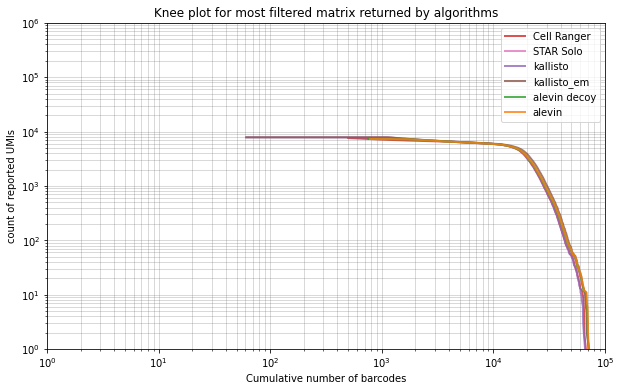

In [65]:
f = pyplot.figure(figsize=(10,6))
ax = f.add_subplot(1,1,1)

alpha = 0.8
gridalpha = 0.5
#max_barcodes = max(cellranger_raw.X.shape[0], solo_raw.X.shape[0], kallisto_raw.X.shape[0], alevin_decoy.X.shape[0], alevin.X.shape[0])
#tenx_ranked_umi[0:np.shape(kallisto.X)[0]], np.arange(np.shape(kallisto.X)[0])

ax.set_title('Knee plot for most filtered matrix returned by algorithms')

cellranger_filtered_ranked_umi = numpy.sort(numpy.array(cellranger_filtered.obs['counts']), axis=None)[::-1]
ax.plot(cellranger_filtered_ranked_umi, range(cellranger_filtered_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['cell ranger'],
        label='Cell Ranger')

solo_filtered_ranked_umi = numpy.sort(numpy.array(solo_filtered.obs['counts']), axis=None)[::-1]
ax.plot(solo_filtered_ranked_umi,  range(solo_filtered_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['star solo'],
        label='STAR Solo')

kallisto_filtered_ranked_umi = numpy.sort(numpy.array(kallisto_filtered.obs['counts']), axis=None)[::-1]
ax.plot(kallisto_filtered_ranked_umi,  range(kallisto_filtered_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['kallisto'],
        label='kallisto')

kallisto_em_filtered_ranked_umi = numpy.sort(numpy.array(kallisto_em_filtered.obs['counts']), axis=None)[::-1]
ax.plot(kallisto_em_filtered_ranked_umi,  range(kallisto_em_filtered_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['kallisto_em'],
        label='kallisto_em')


alevin_decoy_filtered_ranked_umi = numpy.sort(numpy.array(alevin_decoy.obs['counts']), axis=None)[::-1]
ax.plot(alevin_decoy_filtered_ranked_umi,  range(alevin_decoy_filtered_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['alevin decoy'],
        label='alevin decoy')

alevin_filtered_ranked_umi = numpy.sort(numpy.array(alevin.obs['counts']), axis=None)[::-1]
ax.plot(alevin_filtered_ranked_umi,  range(alevin_filtered_ranked_umi.shape[0]), linewidth=2, alpha=alpha,
        c=colors['alevin'],
        label='alevin')

ax.set_xlabel('Cumulative number of barcodes')
ax.set_ylabel('count of reported UMIs')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,1e5)
ax.set_ylim(1,1e6)
ax.grid(
    color="dimgrey", linestyle="-", linewidth=0.5, which="both", alpha=gridalpha
)

ax.legend()
pass

In [35]:
def plot_retained_barcodes(raw, filtered, colormap, label):
    alpha = 0.8
    gridalpha = 0.5

    f = pyplot.figure(figsize=(8,6))
    ax = f.add_subplot(1,1,1)

    dropped_barcodes = list(set(raw.obs_names).difference(filtered.obs_names))
    only_dropped = raw[dropped_barcodes]
    ax.scatter(only_dropped.obs['counts'], only_dropped.obs['ngenes'], s=1, alpha=alpha,
               color=lighten_color(colors[label]))
    ax.scatter(filtered.obs['counts'], filtered.obs['ngenes'], s=1, alpha=alpha,
              color=colors[label])
    ax.set_title(label)
    ax.set_xlim(1, 10e5)
    ax.set_ylim(1, 10e4)
    ax.set_xlabel('barcode counts')
    ax.set_ylabel('genes detected')
    ax.set_xscale('log')
    ax.set_yscale("log", nonpositive='clip')
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    return f
    

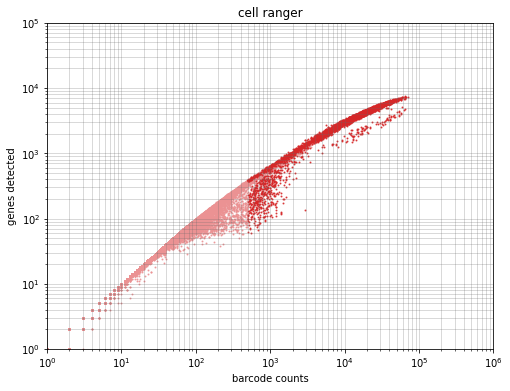

In [36]:
f = plot_retained_barcodes(cellranger_raw, cellranger_filtered, colors, 'cell ranger')
f.savefig(analysis_dir / 'cell_ranger_retained_barcodes.png')

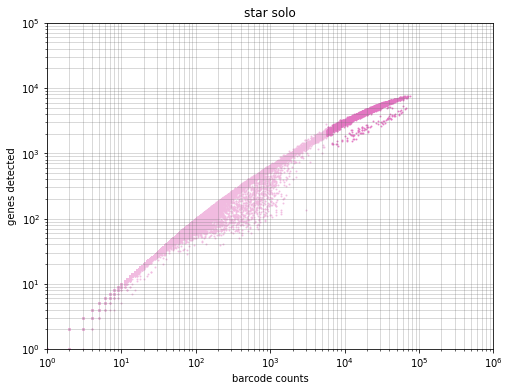

In [37]:
f = plot_retained_barcodes(solo_raw, solo_filtered, colors, 'star solo')
f.savefig(analysis_dir / 'star_solo_retained_barcodes.png')

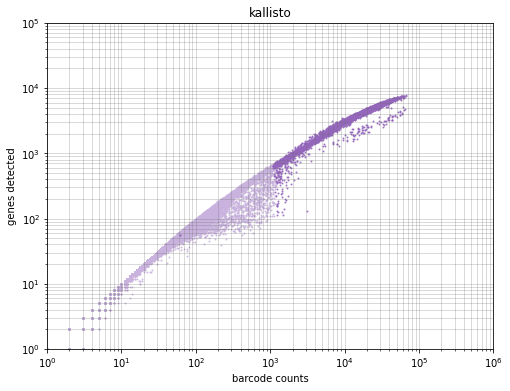

In [38]:
f = plot_retained_barcodes(kallisto_raw, kallisto_filtered, colors, 'kallisto')
f.savefig(analysis_dir / 'kallisto_retained_barcodes.png')

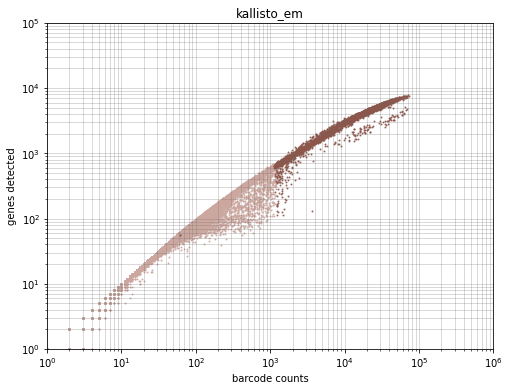

In [39]:
f = plot_retained_barcodes(kallisto_em_raw, kallisto_em_filtered, colors, 'kallisto_em')
f.savefig(analysis_dir / 'kallisto_em_retained_barcodes.png')

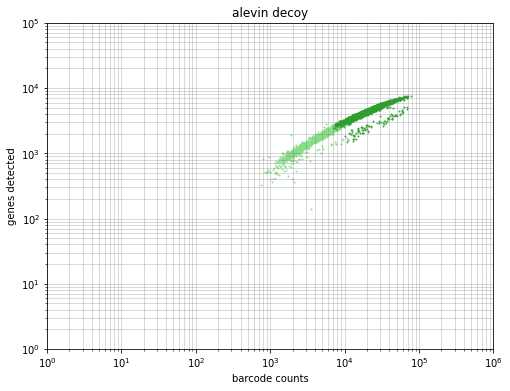

In [40]:
f = plot_retained_barcodes(alevin_decoy, alevin_decoy_filtered, colors, 'alevin decoy')
f.savefig(analysis_dir / 'alevin_decoy_retained_barcodes.png')

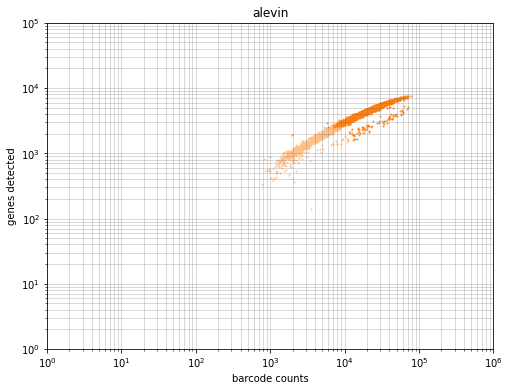

In [41]:
f = plot_retained_barcodes(alevin, alevin_filtered, colors, 'alevin')
f.savefig(analysis_dir / 'alevin_retained_barcodes.png')

# Save results

In [42]:
common_barcodes = list(set(cellranger_filtered.obs_names).intersection(solo_filtered.obs_names).intersection(kallisto_filtered.obs_names).intersection(alevin.obs_names))

In [43]:
len(common_barcodes)

6289

In [44]:
solo_filtered

AnnData object with n_obs × n_vars = 6289 × 31635 
    obs: 'counts', 'ngenes'

In [45]:
alevin.shape

(7302, 31635)

In [46]:
alevin_decoy.shape

(7302, 31635)

In [47]:
assert numpy.all(cellranger_filtered[common_barcodes].obs_names == solo_filtered[common_barcodes].obs_names)
assert numpy.all(cellranger_filtered[common_barcodes].obs_names == kallisto_filtered[common_barcodes].obs_names)
assert numpy.all(cellranger_filtered[common_barcodes].obs_names == kallisto_em_filtered[common_barcodes].obs_names)
assert numpy.all(cellranger_filtered[common_barcodes].obs_names == alevin_decoy[common_barcodes].obs_names)
assert numpy.all(cellranger_filtered[common_barcodes].obs_names == alevin[common_barcodes].obs_names)

In [48]:
assert numpy.all(cellranger_filtered[common_barcodes].var_names == solo_filtered[common_barcodes].var_names)
assert numpy.all(cellranger_filtered[common_barcodes].var_names == kallisto_filtered[common_barcodes].var_names)
assert numpy.all(cellranger_filtered[common_barcodes].var_names == kallisto_em_filtered[common_barcodes].var_names)
assert numpy.all(cellranger_filtered[common_barcodes].var_names == alevin_decoy[common_barcodes].var_names)
assert numpy.all(cellranger_filtered[common_barcodes].var_names == alevin[common_barcodes].var_names)


In [49]:
cellranger_filtered[common_barcodes].write_h5ad(analysis_dir / 'cellranger_filtered.h5ad')
solo_filtered[common_barcodes].write_h5ad(analysis_dir / 'solo_filtered.h5ad')
kallisto_filtered[common_barcodes].write_h5ad(analysis_dir / 'kallisto_filtered.h5ad')
kallisto_em_filtered[common_barcodes].write_h5ad(analysis_dir / 'kallisto_em_filtered.h5ad')
alevin[common_barcodes].write_h5ad(analysis_dir / 'alevin.h5ad')
alevin_decoy[common_barcodes].write_h5ad(analysis_dir / 'alevin_decoy.h5ad')

/usr/lib/python3/dist-packages/anndata/_core/anndata.py:1171: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'gene_symbols' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
